## Machine Learning Workshop

This notebook contains the code for the execises the machine learning workshop.

This first section contains some boilerplate stuff I wrote to help with plotting. You can skip over this to Exercise 1.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def percent_incorrect(y_hat, y_true):
    return np.sum(y_hat == y_true) / y_true.shape[0] * 100

# Exercise 1: Simple Classification

In this exercise we're going to make a simple classifier for the Iris dataset that comes with `sklean`. Here is some code to get you started. Some things to try:
 - Try changing the train/test split value
 - Try changing to use the [KFold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and see this [helper function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).
 - Try change the estimator to use [SVC from the svm module](https://scikit-learn.org/stable/modules/svm.html).


% of labels that were correct: 92.11


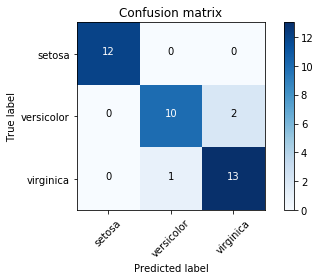

In [17]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import datasets

# Loading the dataset
# - This is just a toy dataset for tutorials from scikit-learn
iris = datasets.load_iris()

# Split our training data into "Training" & "Test" data.
# We will pretend we don't know the labels to the test data so we can check how the model does.
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.25)

# Model fitting
# First create a new estimator. This an Support Vector Machine classifier. The esitmator class
# is called LogisticRegression.
classifier = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=100)
classifier.fit(X_train, y_train)  

# Prediction
# - Use our test dataset to predict a classifier
y_predicted = classifier.predict(X_test)

print("% of labels that were correct: {:.2f}".format(percent_incorrect(y_predicted, y_test)))
# generate the confusion matrix from sklearn
cm = confusion_matrix(y_predicted, y_test)
plot_confusion_matrix(cm, iris.target_names)

# Exercise 2: Clustering

Next up we're going to write some code to do unsupervised learning. Here we'll write use the KMeans clustering algorithm to generate class predictions without using the labels. 
 - Try and measure the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of your clusters.
 - Try changing the [clustering algorithm](https://scikit-learn.org/stable/modules/clustering.html)

In [5]:
from sklearn.cluster import KMeans

# You write some code to cluster the Iris data

# Exercise 3: Titanic Dataset

This the the starter code for the [Titanic Kaggle Problem](https://www.kaggle.com/c/titanic). This code will load the dataset of Titanic passenger info from a CSV file using another helpful library called [pandas](http://pandas.pydata.org/). I also did some cleaning up of the data to help get you started. In the code below I'm just using the same Logistic Regression model that we used in example 1. Think about

 - Different classifiers?
 - Different set of parameters for those classifiers? (read the docs)
 - Invesitgate what the variables are in the Titanic dataset.
      - Can we make or calculate better ones?
      - e.g. I've just encoded all those missing a Cabin enty as 'U' for unknown. Perhaps not being assigned a cabin is particularly important for survival?
          - Maybe make a new boolean variable HasCabin
      - e.g. Some Cabins have multiple entries? Perhaps that relates to the number of children travelling with that passenger? 
          - Maybe make a new boolean variable MultipleCabins

In [5]:
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------------------------
# The following is some boilerplate to load and do a little tidying up
# of the data with pandas. There is also a function here to write out the validation
# set out to file. 
# -------------------------------------------------------------------------------
def read(file_path):
    """ Read a CSV file containing the Titanic dataset
    
    This will do some initial tidying up of the dataset to make the feature columns into
    a state that the model can understand.
    """
    def clean_ticket(df):
        df[['t1', 't2']] = df.Ticket.str.extract("([A-Z][A-Za-z0-9\/.]+)?\s?([0-9]+)")
        return df.fillna({'t1': 'U'})

    # Clean up some of the data to make it more managable
    # You could do more stuff here to make better use of the variable you have
    df = (pd.read_csv(file_path)
            .drop(columns=['Name'])
            .fillna({'Cabin': 'U', 'Embarked': 'U', 'Fare': 0., 'Age': 0})
            .pipe(clean_ticket)
            .drop(columns='Ticket')
            .assign(Cabin=lambda x: pd.Categorical(x['Cabin']).codes,
                    Embarked=lambda x: pd.Categorical(x['Embarked']).codes,
                    Sex=lambda x: pd.Categorical(x['Sex']).codes,
                    t1=lambda x: pd.Categorical(x['t1']).codes,
                    t2=lambda x: pd.Categorical(x['t2']).codes))
    
    if 'Survived' in df.columns:
        # Return both X and y if this is a training dataset
        return df.drop(columns='Survived'), df['Survived'].values
    else:
        # Just return X if this is the test dataset
        return df


def write(file_path, data, pids):
    """ Write a CSV file containing the Titanic dataset predictions"""
    output = pd.Series(data, index=pids, name='Survived')
    output.index.name = "PassengerId"
    output.to_csv(file_path, header=True)

# -------------------------------------------------------------------------------
# The code for training the model starts here
# -------------------------------------------------------------------------------

X, y = read("data/titanic/train.csv")

# Use pandas to show use the to n rows of the data
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,t1,t2
0,1,3,1,22.0,1,0,7.2500,147,2,4,162
1,2,1,0,38.0,1,0,71.2833,81,0,17,126
2,3,3,0,26.0,0,0,7.9250,147,2,36,343
3,4,1,0,35.0,1,0,53.1000,55,2,38,51
4,5,3,1,35.0,0,0,8.0500,147,2,38,595


Below is the actual code for training the model

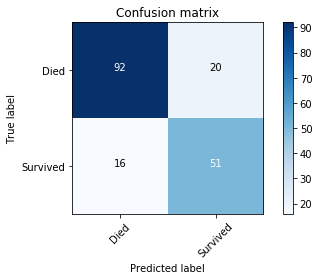

In [10]:
# Split into training & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Classify
classifier = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

# Check our predictions
cm = confusion_matrix(y_predicted, y_test)
plot_confusion_matrix(cm, ['Died', 'Survived'])

### Write Submisson for Kaggle
This will load the validation set, run the classifier, the save the resulting labels in the format expected by Kaggle. I currenty have 76% accuracy on this dataset on kaggle. Play around with the code and see if you can make it higher!

In [11]:
X_validation = read("data/titanic/test.csv")
y_validation = classifier.predict(X_validation)
write("data/submission.csv", y_validation, X_validation['PassengerId'])